In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline


In [2]:
# !pip install numpy


In [16]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None # this is the None version for functions. So a function is stored here, it executes when called later with an object
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) #converts int to Value in cases of Value(2) + 2, technically other is an int and other.data would be undefined
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad # this line accumulates grasdients for repeated variables. eg. if 'a' branches to b and c, back prop from b would update a.grad and back prop from c would overide it. Mathematically, these two should accumulate to get the global gradient
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out
  
  def __radd__(self, other):
    """
    a = Value(2)
    2+a
    to check bugs in expressions above. Python falls back to this method and reverses the order of the elements since the 2 was not a Value type.
    """
    return Value(self.data + other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out

  def __rmul__(self, other):
    """
    a = Value(2)
    2*a
    to check bugs in expressions above. Python falls back to this method and reverses the order of the elements since the 2 was not a Value type.
    """
    return Value(self.data * other)

  def __truediv__(self, other): # self / other
    return self * other**-1 # for divion but a/b -> a*(1/b) = a*b**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other) # the addition operator already defined is used here but negation introduced. This is done immediately above

  def __radd__(self, other): # other + self
    return self + other
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    """
    automated back prop from the given node.
    Takes a node
    Stretches it out to get all chindren node
    Starting from the last node, for each child node it calls node.backward() 
    this executes the function defined to update the gradients and populates the self.grad for all children(nodes)
    """
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0 # this initialises end node gradient to itself to be zero in order to start the back prop properly
    for node in reversed(topo): # populates gradients based on the _backward function for each operation[addition, multiplication, tanh]
      node._backward()




class Neuron:
  
  def __init__(self, nin:int):
    # nin is the number if inputs to the neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x:list): # len(x) == self.w so that the zip can match things out without droping out some
    # w * x + b
    assert(len(self.w) == len(x)), "Input shape does not match input shape of neuron"
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)

    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin:int, nout:int): # number of inputs to each neuron(dim of input) and nout:number of neurons for the layer
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x:list):
    outs = [n(x) for n in self.neurons] # calls each nueron on the input and stores the result in a list from each neuron
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin:int, nouts:list): #nin is the number of inputs to each nueron for first layer. # each successive number defines both output length for a layer and the number of inputs to each neuron of next layer
    # eg. [3,4,2,1] means sample x=[x1,x2,x3]. 3 inputs to each neuron of first layer(4 neurons). This gives 4 outputs serving as input to each neuron of layer2(2 neurons). This outputs 2 numbers as inpput to the last layer with 1 neuron.
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x:list): # s must have same dimention to input of the first layer
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [10]:
x = [2,1]
nin = len(x)
n = Layer(nin, 2)
o = n(x)
b = o[0] + o[1]


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

In [ ]:

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

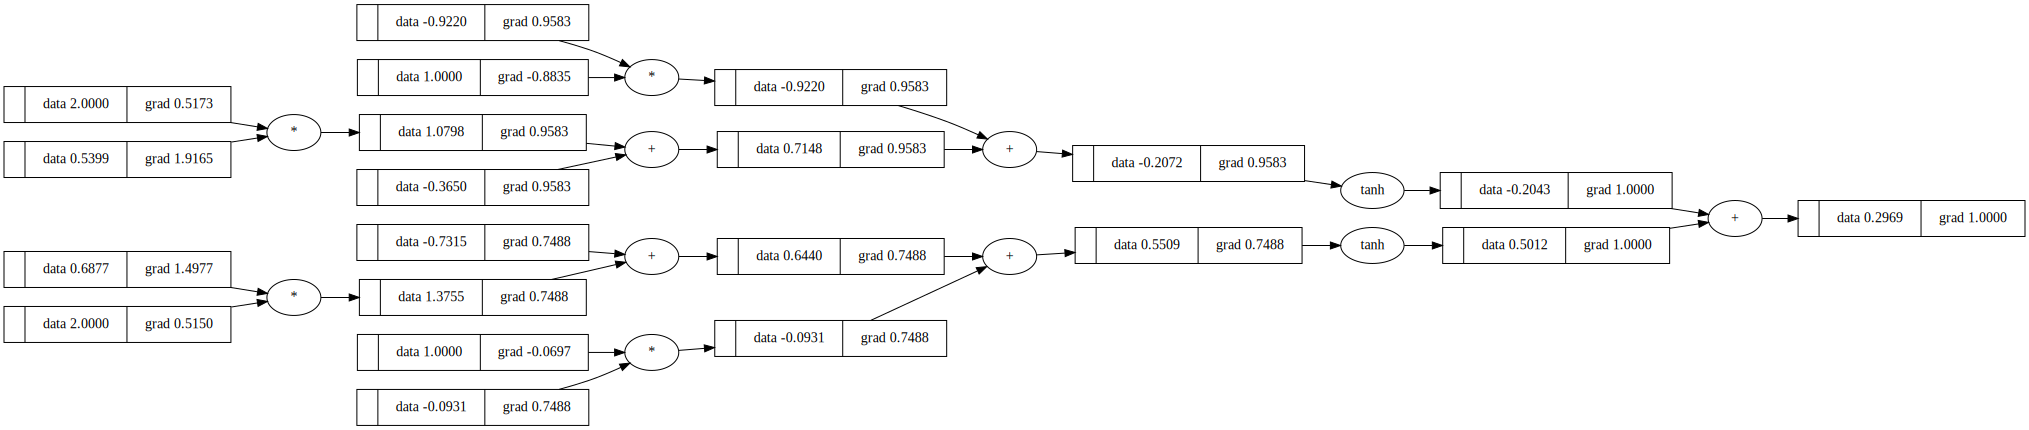

In [15]:
draw_dot(b)

In [14]:
b.backward()

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot